In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [373]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [374]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = 2
std_dev = 1
total_samples = 10000#50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 7000
Validation set size: 1500
Test set size: 1500


In [375]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    # loss_2 = torch.sum(torch.log(det_jacobian + 1e-10))
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-alpha_nll*loss_2)/ dataset_length
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1, loss_2
    return loss_with_alpha, loss_normal

In [376]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

In [377]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o",label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid

In [378]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [379]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2= loss_2.item()
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [380]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [381]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [382]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [383]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.

    Returns:
    None
    """
    num_epochs = len(models_params)
    num_rows = int(np.ceil(np.sqrt(num_epochs)))
    num_cols = int(np.ceil(num_epochs / num_rows))
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for i, ax in enumerate(axes):
        if i < num_epochs:

            #
            if print_model_params:
                print(models_params[i])
            # Load model weights for the current epoch
            load_weights_into_model(model, models_params[i])
            
            # Encode the test data
            with torch.no_grad():
                encoded_test1 = model(test_tensor)
            
            # Plot histogram on the subplot
            ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
            ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
            
            # Set title
            if i == 0:
                ax.set_title("Before Training")
            else:
                ax.set_title(f"Epoch {i}")  # Start epoch count from 1
            ax.set_xlabel("Values")
            ax.set_ylabel("Density")
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


initial nodal_val_locs: tensor([[-9.6834, -9.6485, -7.7583, -7.4109, -6.5123, -5.5542, -3.2026, -2.4208,
         -1.9364, -0.4959,  1.8405,  1.8966,  2.6269,  3.1008,  4.2845,  4.3815,
          4.6280,  4.7911,  6.8143,  8.0134,  9.3828]])
initial fn values: Parameter containing:
tensor([-8.9841, -8.6402, -7.1581, -6.9328, -5.7783, -5.3423, -3.0404, -1.3907,
        -1.5221,  0.3259,  1.9650,  1.9684,  3.2284,  3.2489,  5.2653,  4.6615,
         5.6373,  5.2996,  7.7882,  8.5789, 10.3498], requires_grad=True)
constrained coefficients are:  tensor([-8.8725, -8.8026, -7.3205, -7.0953, -5.9407, -5.5047, -3.2028, -1.6393,
        -1.6344,  0.2135,  1.8527,  1.8561,  3.1161,  3.1366,  5.1529,  5.1539,
         5.6470,  5.6486,  8.1371,  8.9279, 10.6988], grad_fn=<ViewBackward0>)
slopes: constrained coeffs: tensor([[2.0000, 2.0000, 0.7841, 0.6482, 1.2849, 0.4551, 0.9789, 2.0000, 0.0100,
         1.2829, 0.7016, 0.0601, 1.7254, 0.0433, 1.7035, 0.0100, 2.0000, 0.0100,
         1.2300, 0.6595

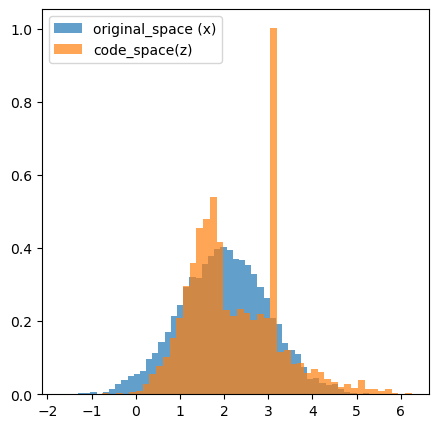

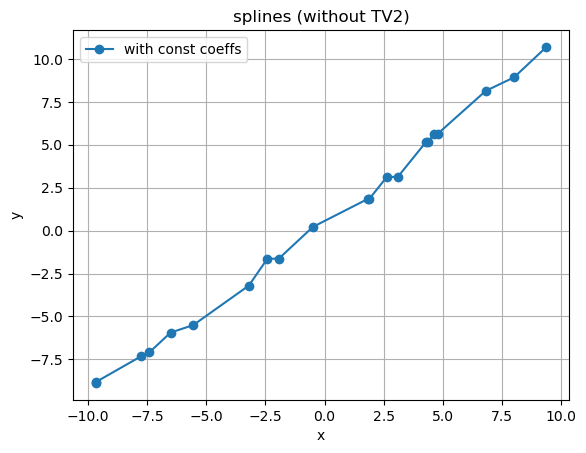

In [384]:
SIZE=21;RANGE=10
model2 = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                        init="random",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) # slopes of splines is 1, obviously

print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0)
plt.legend()
plt.show()

In [385]:
# training
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=60,##40, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls", 
    tv2_regulation=True,
    lambda_tv2=2, # ,
    gamma = 0.1,
    alpha_nll=1 # i introduced this term because the loss_2's values were incredibly small
) 

Training Progress:   2%|▏         | 1/60 [00:11<11:12, 11.39s/it]

Epoch 1/60,  train NLL+2XTV2: 34.63734196963375, data avg loss-1: 48.41104374193166 ,data avg loss-2: -0.0030263735823435325 ,Training NLL Loss: 3.129582269006668, Validation NLL Loss: 2.9972086155668216, LR: 0.0005


Training Progress:   3%|▎         | 2/60 [00:24<11:49, 12.24s/it]

Epoch 2/60,  train NLL+2XTV2: 17.269358057953994, data avg loss-1: 48.634631021926396 ,data avg loss-2: 0.00277670197290917 ,Training NLL Loss: 3.0221128469188465, Validation NLL Loss: 2.9570025040748273, LR: 0.0005


Training Progress:   5%|▌         | 3/60 [00:36<11:46, 12.40s/it]

Epoch 3/60,  train NLL+2XTV2: 14.924171177763917, data avg loss-1: 48.159578375620384 ,data avg loss-2: 0.0010010789246319635 ,Training NLL Loss: 2.983078482488519, Validation NLL Loss: 2.9307599295961095, LR: 0.0005


Training Progress:   7%|▋         | 4/60 [00:49<11:43, 12.56s/it]

Epoch 4/60,  train NLL+2XTV2: 13.917079189596656, data avg loss-1: 47.76993922664695 ,data avg loss-2: 0.0003574908324028259 ,Training NLL Loss: 2.962429218096276, Validation NLL Loss: 2.913605696343361, LR: 0.0005


Training Progress:   8%|▊         | 5/60 [01:02<11:29, 12.55s/it]

Epoch 5/60,  train NLL+2XTV2: 13.604466020244441, data avg loss-1: 47.273816435304404 ,data avg loss-2: 0.000901758398639557 ,Training NLL Loss: 2.9442653737656057, Validation NLL Loss: 2.8999042967532542, LR: 0.0005


Training Progress:  10%|█         | 6/60 [01:14<11:19, 12.58s/it]

Epoch 6/60,  train NLL+2XTV2: 13.323142341282814, data avg loss-1: 46.768980587998485 ,data avg loss-2: -0.0006110304838990512 ,Training NLL Loss: 2.9273123809191732, Validation NLL Loss: 2.8835688715285444, LR: 0.0005


Training Progress:  12%|█▏        | 7/60 [01:27<11:06, 12.57s/it]

Epoch 7/60,  train NLL+2XTV2: 13.04156015561596, data avg loss-1: 46.12036058347519 ,data avg loss-2: 0.0015339384612427455 ,Training NLL Loss: 2.9068532558880986, Validation NLL Loss: 2.8586285380606955, LR: 0.0005


Training Progress:  13%|█▎        | 8/60 [01:40<10:58, 12.66s/it]

Epoch 8/60,  train NLL+2XTV2: 12.761334441023875, data avg loss-1: 45.303253017059745 ,data avg loss-2: -0.00032138875494264576 ,Training NLL Loss: 2.874522465276936, Validation NLL Loss: 2.8131821776958224, LR: 0.0005


Training Progress:  15%|█▌        | 9/60 [01:52<10:47, 12.70s/it]

Epoch 9/60,  train NLL+2XTV2: 12.539091656741487, data avg loss-1: 44.08395520737182 ,data avg loss-2: -0.0007376877684571428 ,Training NLL Loss: 2.806099615140593, Validation NLL Loss: 2.7331963549269007, LR: 0.0005


Training Progress:  17%|█▋        | 10/60 [02:05<10:33, 12.66s/it]

Epoch 10/60,  train NLL+2XTV2: 12.391133526144507, data avg loss-1: 42.62729655226616 ,data avg loss-2: -0.0007416980859895819 ,Training NLL Loss: 2.717828022018415, Validation NLL Loss: 2.6350908216009747, LR: 0.0005


Training Progress:  18%|█▊        | 11/60 [02:18<10:20, 12.66s/it]

Epoch 11/60,  train NLL+2XTV2: 12.241912476003986, data avg loss-1: 41.08956679252729 ,data avg loss-2: -0.0007417319708218858 ,Training NLL Loss: 2.6217006774253497, Validation NLL Loss: 2.545201713734485, LR: 0.0005


Training Progress:  20%|██        | 12/60 [02:30<10:05, 12.61s/it]

Epoch 12/60,  train NLL+2XTV2: 12.091076892260547, data avg loss-1: 39.72884131348841 ,data avg loss-2: -0.0007575650329459204 ,Training NLL Loss: 2.5344063762116105, Validation NLL Loss: 2.463510789769761, LR: 0.0005


Training Progress:  22%|██▏       | 13/60 [02:43<09:52, 12.60s/it]

Epoch 13/60,  train NLL+2XTV2: 11.937007313993968, data avg loss-1: 38.356631714459425 ,data avg loss-2: -0.0007489625721761625 ,Training NLL Loss: 2.4489499267922143, Validation NLL Loss: 2.3779875179554555, LR: 0.0005


Training Progress:  23%|██▎       | 14/60 [02:55<09:37, 12.56s/it]

Epoch 14/60,  train NLL+2XTV2: 11.784559811631294, data avg loss-1: 37.00343857508272 ,data avg loss-2: -0.0007862813396540951 ,Training NLL Loss: 2.365766245752709, Validation NLL Loss: 2.294191871551757, LR: 0.0005


Training Progress:  25%|██▌       | 15/60 [03:08<09:25, 12.57s/it]

Epoch 15/60,  train NLL+2XTV2: 11.624780319597079, data avg loss-1: 35.6340850520896 ,data avg loss-2: -0.0007752107294727134 ,Training NLL Loss: 2.280054024909729, Validation NLL Loss: 2.209375007355467, LR: 0.0005


Training Progress:  27%|██▋       | 16/60 [03:20<09:12, 12.55s/it]

Epoch 16/60,  train NLL+2XTV2: 11.464070712050347, data avg loss-1: 34.29519545759785 ,data avg loss-2: -0.0007490250345778791 ,Training NLL Loss: 2.1954045427716484, Validation NLL Loss: 2.1304604778898524, LR: 0.0005


Training Progress:  28%|██▊       | 17/60 [03:33<09:00, 12.57s/it]

Epoch 17/60,  train NLL+2XTV2: 11.31222855554868, data avg loss-1: 33.01670600725635 ,data avg loss-2: -0.0007851989301916672 ,Training NLL Loss: 2.1168498983394066, Validation NLL Loss: 2.0499099518390413, LR: 0.0005


Training Progress:  30%|███       | 18/60 [03:46<08:47, 12.57s/it]

Epoch 18/60,  train NLL+2XTV2: 11.156603717368487, data avg loss-1: 31.735491270344006 ,data avg loss-2: -0.0007781597305106246 ,Training NLL Loss: 2.036004974281407, Validation NLL Loss: 1.9720390439033508, LR: 0.0005


Training Progress:  32%|███▏      | 19/60 [03:58<08:34, 12.54s/it]

Epoch 19/60,  train NLL+2XTV2: 11.001714882785327, data avg loss-1: 30.479921223366098 ,data avg loss-2: -0.0008088317635941179 ,Training NLL Loss: 1.9591256279379266, Validation NLL Loss: 1.8945160888611001, LR: 0.0005


Training Progress:  33%|███▎      | 20/60 [04:11<08:25, 12.63s/it]

Epoch 20/60,  train NLL+2XTV2: 10.844754504286536, data avg loss-1: 29.23326353830834 ,data avg loss-2: -0.0008275595293741792 ,Training NLL Loss: 1.8816060391190934, Validation NLL Loss: 1.8198884586070447, LR: 0.0005


Training Progress:  35%|███▌      | 21/60 [04:24<08:12, 12.64s/it]

Epoch 21/60,  train NLL+2XTV2: 10.690768733960853, data avg loss-1: 28.03628938927498 ,data avg loss-2: -0.0008424811031176075 ,Training NLL Loss: 1.8071452731683375, Validation NLL Loss: 1.7467470295885776, LR: 0.0005


Training Progress:  37%|███▋      | 22/60 [04:36<07:55, 12.52s/it]

Epoch 22/60,  train NLL+2XTV2: 10.538278978164882, data avg loss-1: 26.866710122861818 ,data avg loss-2: -0.011254572977214099 ,Training NLL Loss: 1.7362652559802956, Validation NLL Loss: 1.6742667181694761, LR: 0.0005


Training Progress:  38%|███▊      | 23/60 [04:49<07:46, 12.60s/it]

Epoch 23/60,  train NLL+2XTV2: 10.3832795783265, data avg loss-1: 25.71261038192331 ,data avg loss-2: -0.0008209231373381941 ,Training NLL Loss: 1.662658802722687, Validation NLL Loss: 1.6039241717216817, LR: 0.0005


Training Progress:  40%|████      | 24/60 [05:01<07:34, 12.63s/it]

Epoch 24/60,  train NLL+2XTV2: 10.236732426299351, data avg loss-1: 24.610742320753122 ,data avg loss-2: 0.002518698777237984 ,Training NLL Loss: 1.5970409104268846, Validation NLL Loss: 1.5384496995743284, LR: 0.0005


Training Progress:  42%|████▏     | 25/60 [05:14<07:23, 12.68s/it]

Epoch 25/60,  train NLL+2XTV2: 10.086037727251444, data avg loss-1: 23.558094830273493 ,data avg loss-2: -0.0008543992423575763 ,Training NLL Loss: 1.5277002509598319, Validation NLL Loss: 1.47523037486888, LR: 0.0005


Training Progress:  43%|████▎     | 26/60 [05:26<07:07, 12.57s/it]

Epoch 26/60,  train NLL+2XTV2: 9.94241754105102, data avg loss-1: 22.544830006551525 ,data avg loss-2: -0.0008543374603741789 ,Training NLL Loss: 1.4650366710473413, Validation NLL Loss: 1.4120845204972206, LR: 0.0005


Training Progress:  45%|████▌     | 27/60 [05:39<06:55, 12.60s/it]

Epoch 27/60,  train NLL+2XTV2: 9.799514620271447, data avg loss-1: 21.55005545158909 ,data avg loss-2: -0.000899223023897981 ,Training NLL Loss: 1.4046859471765283, Validation NLL Loss: 1.3533182239278834, LR: 0.0005


Training Progress:  47%|████▋     | 28/60 [05:52<06:43, 12.61s/it]

Epoch 28/60,  train NLL+2XTV2: 9.661608351964384, data avg loss-1: 20.61692084569365 ,data avg loss-2: -0.0009256494507942026 ,Training NLL Loss: 1.3455704622072717, Validation NLL Loss: 1.2968024053472154, LR: 0.0005


Training Progress:  48%|████▊     | 29/60 [06:04<06:29, 12.58s/it]

Epoch 29/60,  train NLL+2XTV2: 9.52036785535072, data avg loss-1: 19.687212370302035 ,data avg loss-2: -0.0008688910638905007 ,Training NLL Loss: 1.2872742916623208, Validation NLL Loss: 1.2396593474327249, LR: 0.0005


Training Progress:  50%|█████     | 30/60 [06:17<06:18, 12.63s/it]

Epoch 30/60,  train NLL+2XTV2: 9.380902346955043, data avg loss-1: 18.780302520211972 ,data avg loss-2: -0.0008879792472543238 ,Training NLL Loss: 1.231388449328675, Validation NLL Loss: 1.1845025559689135, LR: 0.0005


Training Progress:  52%|█████▏    | 31/60 [06:30<06:14, 12.91s/it]

Epoch 31/60,  train NLL+2XTV2: 9.247570549516373, data avg loss-1: 17.930490914000767 ,data avg loss-2: -0.0008723397641421453 ,Training NLL Loss: 1.1774913246773149, Validation NLL Loss: 1.1348793551008751, LR: 0.0005


Training Progress:  53%|█████▎    | 32/60 [06:44<06:03, 12.99s/it]

Epoch 32/60,  train NLL+2XTV2: 9.118261163093184, data avg loss-1: 17.12537843506086 ,data avg loss-2: -0.000906760766081614 ,Training NLL Loss: 1.1289259564114489, Validation NLL Loss: 1.0917111812753881, LR: 0.0005


Training Progress:  55%|█████▌    | 33/60 [06:55<05:37, 12.49s/it]

Epoch 33/60,  train NLL+2XTV2: 9.06190362912879, data avg loss-1: 16.647716971837223 ,data avg loss-2: -0.0009516976331466954 ,Training NLL Loss: 1.1001933331358922, Validation NLL Loss: 1.0724818015352209, LR: 0.0005


Training Progress:  57%|█████▋    | 34/60 [07:06<05:15, 12.14s/it]

Epoch 34/60,  train NLL+2XTV2: 9.042284349328307, data avg loss-1: 16.3241444102161 ,data avg loss-2: -0.0008928864922153351 ,Training NLL Loss: 1.0808398727684805, Validation NLL Loss: 1.0545885125373273, LR: 0.0005


Training Progress:  58%|█████▊    | 35/60 [07:18<04:57, 11.88s/it]

Epoch 35/60,  train NLL+2XTV2: 9.021412851603609, data avg loss-1: 16.009959392351647 ,data avg loss-2: -0.0009059827757752649 ,Training NLL Loss: 1.0607043440755644, Validation NLL Loss: 1.0312863746856122, LR: 0.0005


Training Progress:  60%|██████    | 36/60 [07:29<04:38, 11.62s/it]

Epoch 36/60,  train NLL+2XTV2: 9.000608372361693, data avg loss-1: 15.66018222673843 ,data avg loss-2: -0.0009426818862897621 ,Training NLL Loss: 1.0384142413803432, Validation NLL Loss: 1.0110903540824323, LR: 0.0005


Training Progress:  62%|██████▏   | 37/60 [07:40<04:25, 11.56s/it]

Epoch 37/60,  train NLL+2XTV2: 8.978265167915659, data avg loss-1: 15.322404288810137 ,data avg loss-2: -0.0009531734604813737 ,Training NLL Loss: 1.0174295059894318, Validation NLL Loss: 0.989775538444519, LR: 0.0005


Training Progress:  63%|██████▎   | 38/60 [07:51<04:12, 11.48s/it]

Epoch 38/60,  train NLL+2XTV2: 8.959421645560765, data avg loss-1: 14.97475843124738 ,data avg loss-2: 0.0007731419856145501 ,Training NLL Loss: 0.9966628141871327, Validation NLL Loss: 0.9699023816179722, LR: 0.0005


Training Progress:  65%|██████▌   | 39/60 [08:06<04:24, 12.59s/it]

Epoch 39/60,  train NLL+2XTV2: 8.936424159568194, data avg loss-1: 14.627286727025629 ,data avg loss-2: -0.0010072752220989906 ,Training NLL Loss: 0.9751729054129832, Validation NLL Loss: 0.9480720168732583, LR: 0.0005


Training Progress:  67%|██████▋   | 40/60 [08:20<04:15, 12.78s/it]

Epoch 40/60,  train NLL+2XTV2: 8.915383193046535, data avg loss-1: 14.270856709240778 ,data avg loss-2: -0.0010136129104927794 ,Training NLL Loss: 0.9540177275464959, Validation NLL Loss: 0.9285846999351014, LR: 0.0005


Training Progress:  68%|██████▊   | 41/60 [08:31<03:54, 12.32s/it]

Epoch 41/60,  train NLL+2XTV2: 8.892355470352522, data avg loss-1: 13.926688560612126 ,data avg loss-2: -0.0009361236062768387 ,Training NLL Loss: 0.9314197892467725, Validation NLL Loss: 0.9042620544737958, LR: 0.0005


Training Progress:  70%|███████   | 42/60 [08:42<03:35, 12.00s/it]

Epoch 42/60,  train NLL+2XTV2: 8.86967771347255, data avg loss-1: 13.54941580175809 ,data avg loss-2: -0.0009610145331517746 ,Training NLL Loss: 0.9086700049165177, Validation NLL Loss: 0.8806496107197822, LR: 0.0005


Training Progress:  72%|███████▏  | 43/60 [08:54<03:21, 11.85s/it]

Epoch 43/60,  train NLL+2XTV2: 8.847335880749846, data avg loss-1: 13.182211319605509 ,data avg loss-2: 0.000764931513838572 ,Training NLL Loss: 0.8856200692180085, Validation NLL Loss: 0.8598474704838813, LR: 0.0005


Training Progress:  73%|███████▎  | 44/60 [09:05<03:07, 11.75s/it]

Epoch 44/60,  train NLL+2XTV2: 8.825893164769699, data avg loss-1: 12.819759588807685 ,data avg loss-2: -0.0009720435697738438 ,Training NLL Loss: 0.8644093876559985, Validation NLL Loss: 0.8386580303628394, LR: 0.0005


Training Progress:  75%|███████▌  | 45/60 [09:15<02:47, 11.15s/it]

Epoch 45/60,  train NLL+2XTV2: 8.802573554592046, data avg loss-1: 12.417538848097466 ,data avg loss-2: 0.000699263593377588 ,Training NLL Loss: 0.8412085611662364, Validation NLL Loss: 0.8136182864929767, LR: 0.0005


Training Progress:  77%|███████▋  | 46/60 [09:24<02:29, 10.65s/it]

Epoch 46/60,  train NLL+2XTV2: 8.777210692836814, data avg loss-1: 12.010305110178038 ,data avg loss-2: -0.0010470956836116912 ,Training NLL Loss: 0.8164143455491218, Validation NLL Loss: 0.7895160269864062, LR: 0.0005


Training Progress:  78%|███████▊  | 47/60 [09:36<02:20, 10.83s/it]

Epoch 47/60,  train NLL+2XTV2: 8.751391382522234, data avg loss-1: 11.637712554300212 ,data avg loss-2: -0.0009909029964987 ,Training NLL Loss: 0.7908632845775178, Validation NLL Loss: 0.7646314485910091, LR: 0.0005


Training Progress:  80%|████████  | 48/60 [09:47<02:11, 10.92s/it]

Epoch 48/60,  train NLL+2XTV2: 8.731751006487842, data avg loss-1: 11.27466579387177 ,data avg loss-2: -0.0011642157487128967 ,Training NLL Loss: 0.7695097500739032, Validation NLL Loss: 0.7466261786349276, LR: 0.0005


Training Progress:  82%|████████▏ | 49/60 [09:58<02:01, 11.03s/it]

Epoch 49/60,  train NLL+2XTV2: 8.709759627303033, data avg loss-1: 10.942120708423118 ,data avg loss-2: -0.0009317399432125701 ,Training NLL Loss: 0.749188743497683, Validation NLL Loss: 0.7264971907468553, LR: 0.0005


Training Progress:  83%|████████▎ | 50/60 [10:10<01:51, 11.18s/it]

Epoch 50/60,  train NLL+2XTV2: 8.688048597884505, data avg loss-1: 10.594097963206844 ,data avg loss-2: -0.0010449578772941137 ,Training NLL Loss: 0.7265357349289062, Validation NLL Loss: 0.7025442402413551, LR: 0.0005


Training Progress:  85%|████████▌ | 51/60 [10:21<01:40, 11.17s/it]

Epoch 51/60,  train NLL+2XTV2: 8.665384630090026, data avg loss-1: 10.201159643800292 ,data avg loss-2: -0.0011273613667379231 ,Training NLL Loss: 0.7043573676723324, Validation NLL Loss: 0.68274809483518, LR: 0.0005


Training Progress:  87%|████████▋ | 52/60 [10:32<01:29, 11.17s/it]

Epoch 52/60,  train NLL+2XTV2: 8.646002268682333, data avg loss-1: 9.89549237625784 ,data avg loss-2: -0.0010460449816429452 ,Training NLL Loss: 0.6855994402409689, Validation NLL Loss: 0.6644796456428285, LR: 0.0005


Training Progress:  88%|████████▊ | 53/60 [10:43<01:17, 11.09s/it]

Epoch 53/60,  train NLL+2XTV2: 8.626348913532414, data avg loss-1: 9.595508314158819 ,data avg loss-2: 0.0006890907951685936 ,Training NLL Loss: 0.6658599165748788, Validation NLL Loss: 0.6441064565739734, LR: 0.0005


Training Progress:  90%|█████████ | 54/60 [10:53<01:04, 10.77s/it]

Epoch 54/60,  train NLL+2XTV2: 8.607974770950944, data avg loss-1: 9.292579819078314 ,data avg loss-2: -0.0010210351176457863 ,Training NLL Loss: 0.6459069287395913, Validation NLL Loss: 0.6288068351593423, LR: 0.0005


Training Progress:  92%|█████████▏| 55/60 [11:03<00:52, 10.52s/it]

Epoch 55/60,  train NLL+2XTV2: 8.593683754472428, data avg loss-1: 9.019870060219612 ,data avg loss-2: -0.0011177335155608992 ,Training NLL Loss: 0.6327620380000981, Validation NLL Loss: 0.6160341662929413, LR: 0.0005


Training Progress:  93%|█████████▎| 56/60 [11:13<00:41, 10.44s/it]

Epoch 56/60,  train NLL+2XTV2: 8.579185514145246, data avg loss-1: 8.804551432121833 ,data avg loss-2: -0.0011139825054499656 ,Training NLL Loss: 0.6188510786316711, Validation NLL Loss: 0.6015761079306298, LR: 0.0005


Training Progress:  95%|█████████▌| 57/60 [11:26<00:33, 11.15s/it]

Epoch 57/60,  train NLL+2XTV2: 8.565983460918408, data avg loss-1: 8.60423190571946 ,data avg loss-2: -0.0010299435625337574 ,Training NLL Loss: 0.6050810455663563, Validation NLL Loss: 0.5891244059547465, LR: 0.0005


Training Progress:  97%|█████████▋| 58/60 [11:37<00:22, 11.21s/it]

Epoch 58/60,  train NLL+2XTV2: 8.553855898173433, data avg loss-1: 8.365185018543784 ,data avg loss-2: -0.0012248120351469136 ,Training NLL Loss: 0.5926519380584699, Validation NLL Loss: 0.577656794101634, LR: 0.0005


Training Progress:  98%|█████████▊| 59/60 [11:48<00:11, 11.15s/it]

Epoch 59/60,  train NLL+2XTV2: 8.542802002876316, data avg loss-1: 8.154819866021475 ,data avg loss-2: 0.0023658776392131093 ,Training NLL Loss: 0.582148902526457, Validation NLL Loss: 0.5686370606752152, LR: 0.0005


Training Progress: 100%|██████████| 60/60 [11:59<00:00, 12.00s/it]

Epoch 60/60,  train NLL+2XTV2: 8.534317480374689, data avg loss-1: 8.036658361622187 ,data avg loss-2: 0.0006962679836848011 ,Training NLL Loss: 0.5740294177510422, Validation NLL Loss: 0.5612961050677807, LR: 0.0005
Training complete


In [387]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=5000,
                    print_model_params=0
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                            ],

                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y")
    plt.legend()
    plt.show()
    ## 
    print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    plot_coefficients_evolution(num_coeffs,
                                np.array(coeffs_unconstrained_evol2), 
                                np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) # slopes of splines is 1, obviously
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params)


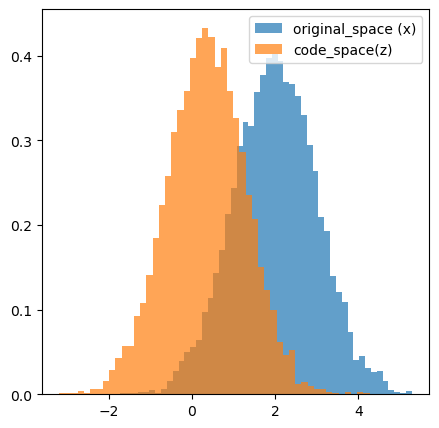

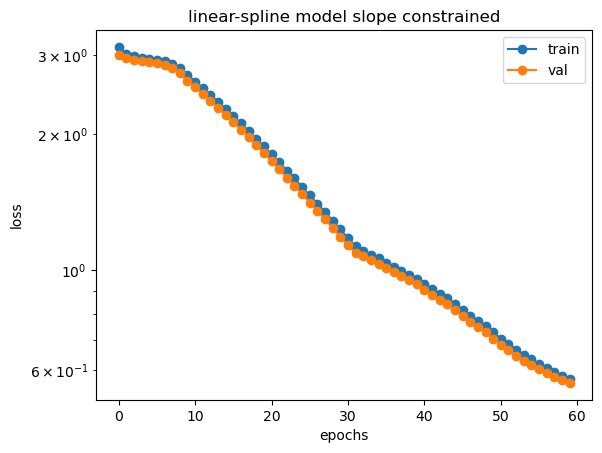

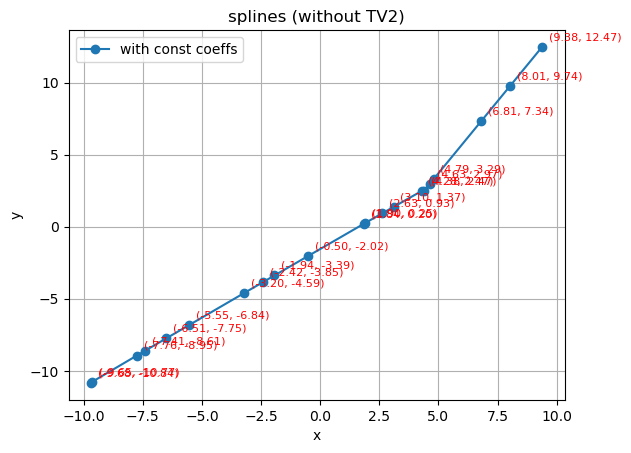

slopes: constrained coeffs: tensor([[2.0000, 2.0000, 0.9653, 0.9587, 0.9588, 0.9549, 0.9547, 0.9524, 0.9511,
         0.9491, 0.9486, 0.9423, 0.9312, 0.9306, 0.9283, 0.0100, 2.0000, 2.0000,
         2.0000, 2.0000, 2.0000]], grad_fn=<ClampBackward1>)


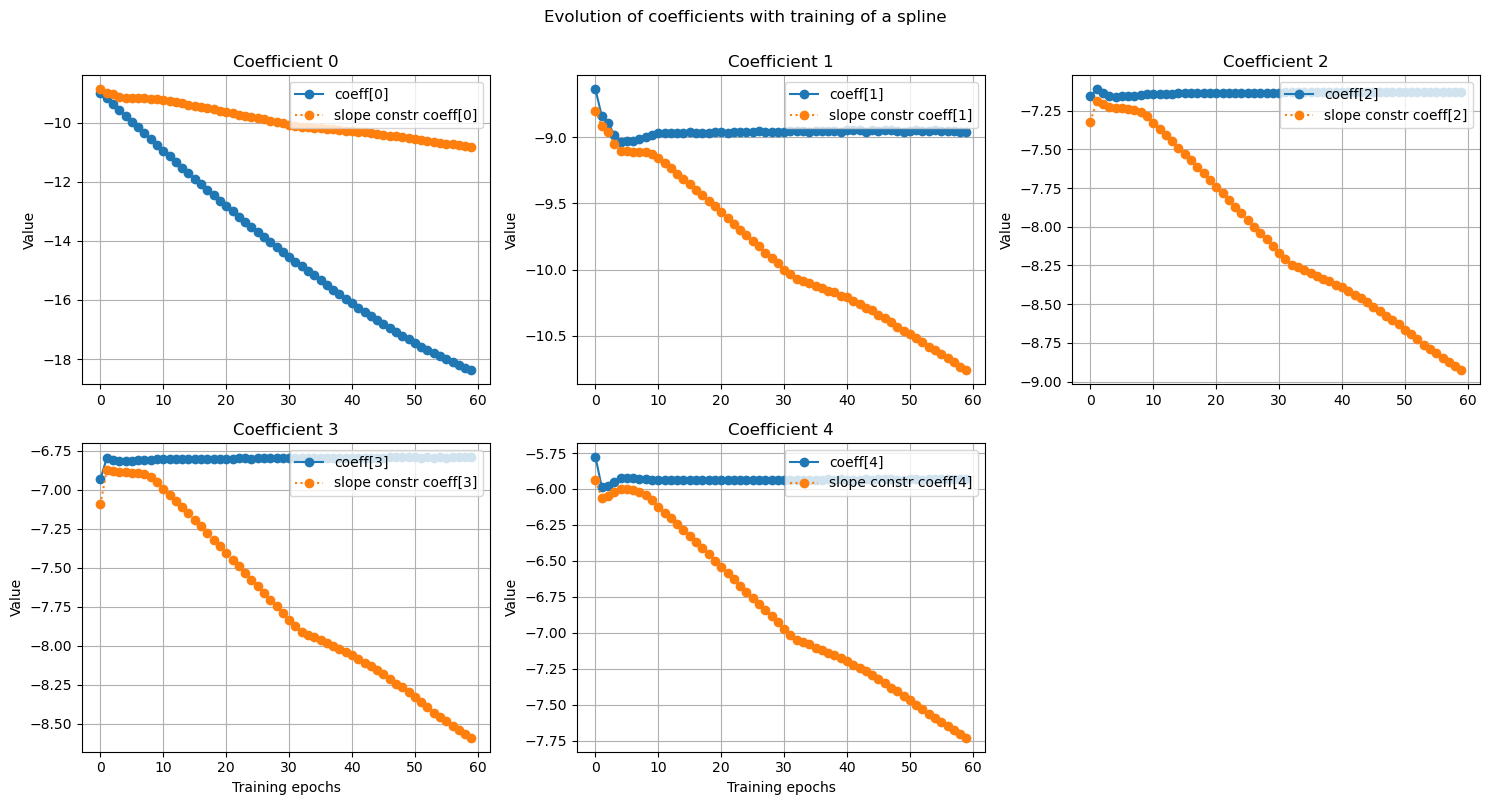

initial nodal_val_locs: tensor([[-9.6834, -9.6485, -7.7583, -7.4109, -6.5123, -5.5542, -3.2026, -2.4208,
         -1.9364, -0.4959,  1.8405,  1.8966,  2.6269,  3.1008,  4.2845,  4.3815,
          4.6280,  4.7911,  6.8143,  8.0134,  9.3828]])
initial fn values: Parameter containing:
tensor([9.6834, 9.6485, 7.7583, 7.4109, 6.5123, 5.5542, 3.2026, 2.4208, 1.9364,
        0.4959, 1.8405, 1.8966, 2.6269, 3.1008, 4.2845, 4.3815, 4.6280, 4.7911,
        6.8143, 8.0134, 9.3828], requires_grad=True)


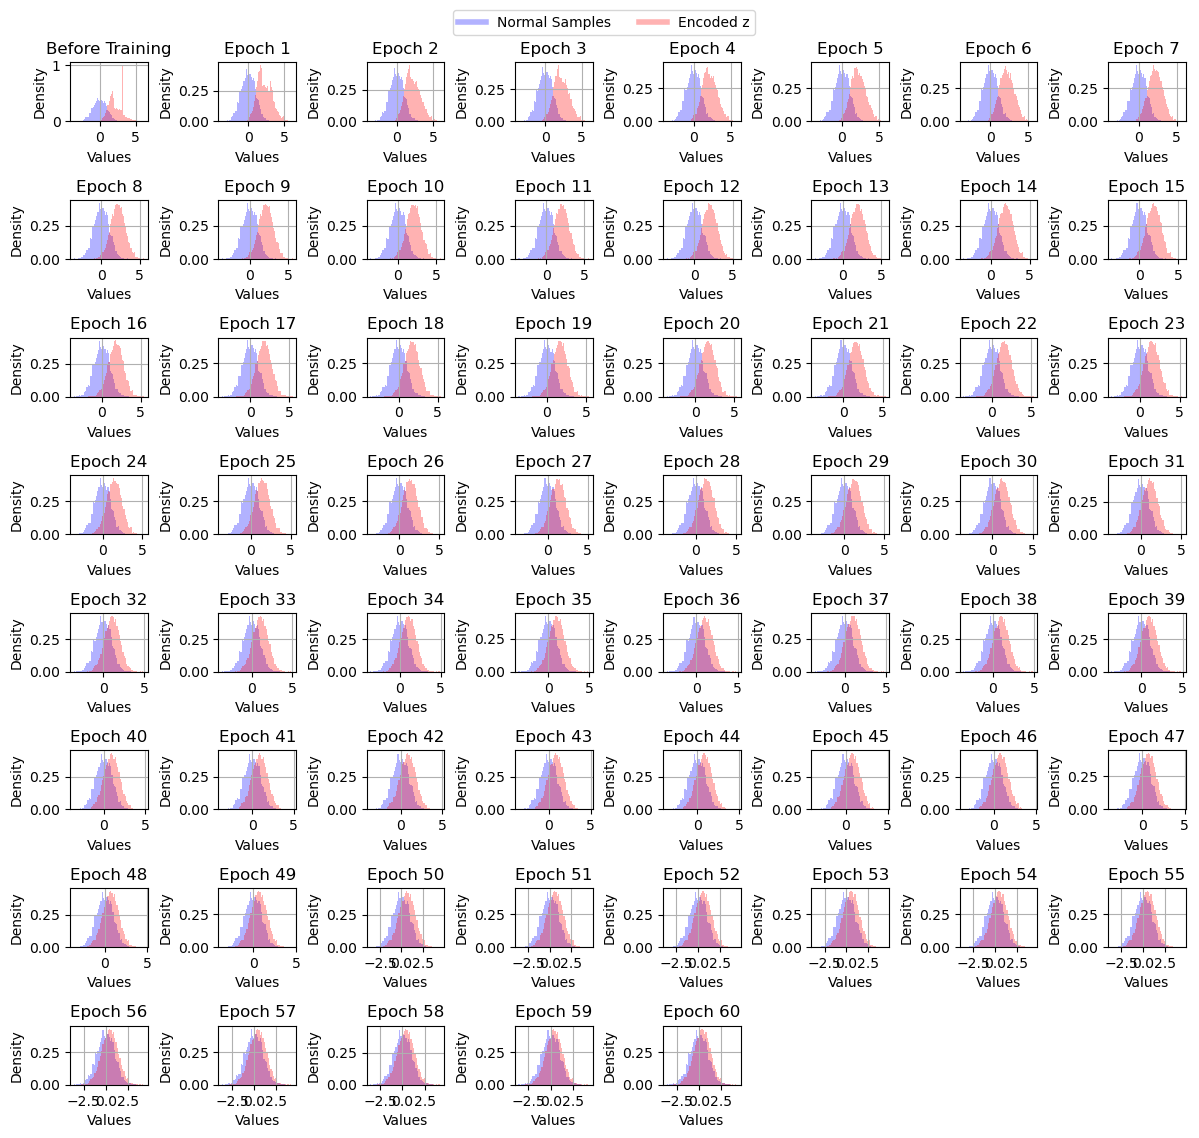

In [388]:
analyse_training(model_in=model2,train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data, model_params_list=epoch_wise_param_list,
                num_coeffs=5,print_model_params=0)

In [144]:
# let's train it for 20 more epochs and see how the training dynamics  further looks like
# training
train_loss2_1, val_loss2_1, epoch_wise_param_list_1,coeffs_unconstrained_evol2_1, coeffs_const_evol2_1 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=20, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2 
)  

Training Progress:   5%|▌         | 1/20 [00:26<08:18, 26.23s/it]

Epoch 1/20,  train NLL+2XTV2: 0.7224247887947668, Training NLL Loss: 0.7212728261692256, Validation NLL Loss: 0.7092582441568375, LR: 0.0005


Training Progress:  10%|█         | 2/20 [00:50<07:35, 25.29s/it]

Epoch 2/20,  train NLL+2XTV2: 0.7142190912414434, Training NLL Loss: 0.712998650361558, Validation NLL Loss: 0.7014061361551285, LR: 0.0005


Training Progress:  15%|█▌        | 3/20 [01:17<07:20, 25.88s/it]

Epoch 3/20,  train NLL+2XTV2: 0.706521720179351, Training NLL Loss: 0.70534595939065, Validation NLL Loss: 0.6938754928708076, LR: 0.0005


Training Progress:  20%|██        | 4/20 [01:45<07:07, 26.73s/it]

Epoch 4/20,  train NLL+2XTV2: 0.7002371641541508, Training NLL Loss: 0.6990258261727388, Validation NLL Loss: 0.6883005385398865, LR: 0.0005


Training Progress:  25%|██▌       | 5/20 [02:12<06:41, 26.75s/it]

Epoch 5/20,  train NLL+2XTV2: 0.6948330583818569, Training NLL Loss: 0.693686499080805, Validation NLL Loss: 0.6834913918972015, LR: 0.0005


Training Progress:  30%|███       | 6/20 [02:35<05:57, 25.53s/it]

Epoch 6/20,  train NLL+2XTV2: 0.6911890817281009, Training NLL Loss: 0.6900728544876324, Validation NLL Loss: 0.680564884185791, LR: 0.0005


Training Progress:  35%|███▌      | 7/20 [03:01<05:33, 25.63s/it]

Epoch 7/20,  train NLL+2XTV2: 0.6878190962238606, Training NLL Loss: 0.686556794943213, Validation NLL Loss: 0.6770535960793496, LR: 0.0005


Training Progress:  40%|████      | 8/20 [03:28<05:13, 26.09s/it]

Epoch 8/20,  train NLL+2XTV2: 0.6849180364976505, Training NLL Loss: 0.6837776472094536, Validation NLL Loss: 0.6747855592370033, LR: 0.0005


Training Progress:  45%|████▌     | 9/20 [03:52<04:39, 25.43s/it]

Epoch 9/20,  train NLL+2XTV2: 0.6825101231037294, Training NLL Loss: 0.6812988746058971, Validation NLL Loss: 0.6722670513987541, LR: 0.0005


Training Progress:  50%|█████     | 10/20 [04:15<04:06, 24.62s/it]

Epoch 10/20,  train NLL+2XTV2: 0.6804568593764571, Training NLL Loss: 0.6792337795481685, Validation NLL Loss: 0.6711075212955475, LR: 0.0005


Training Progress:  55%|█████▌    | 11/20 [04:38<03:37, 24.14s/it]

Epoch 11/20,  train NLL+2XTV2: 0.6794075250702223, Training NLL Loss: 0.6781723074353242, Validation NLL Loss: 0.6696471425890923, LR: 0.0005


Training Progress:  60%|██████    | 12/20 [05:01<03:10, 23.81s/it]

Epoch 12/20,  train NLL+2XTV2: 0.6786435727850433, Training NLL Loss: 0.6774416487750173, Validation NLL Loss: 0.6697499679923058, LR: 0.0005


Training Progress:  65%|██████▌   | 13/20 [05:28<02:53, 24.83s/it]

Epoch 13/20,  train NLL+2XTV2: 0.6779065357254628, Training NLL Loss: 0.6766639310473954, Validation NLL Loss: 0.6689425562620163, LR: 0.0005


Training Progress:  70%|███████   | 14/20 [05:55<02:33, 25.50s/it]

Epoch 14/20,  train NLL+2XTV2: 0.6777637514454131, Training NLL Loss: 0.6765590351212198, Validation NLL Loss: 0.6692251658439636, LR: 0.0005


Training Progress:  75%|███████▌  | 15/20 [06:22<02:10, 26.05s/it]

Epoch 15/20,  train NLL+2XTV2: 0.6778817888933466, Training NLL Loss: 0.6766295844837449, Validation NLL Loss: 0.668752921283245, LR: 0.0005


Training Progress:  80%|████████  | 16/20 [06:48<01:43, 25.99s/it]

Epoch 16/20,  train NLL+2XTV2: 0.6777322027375786, Training NLL Loss: 0.6764612743613448, Validation NLL Loss: 0.6693154361844063, LR: 0.0005


Training Progress:  85%|████████▌ | 17/20 [07:17<01:20, 26.87s/it]

Epoch 17/20,  train NLL+2XTV2: 0.6778598988321773, Training NLL Loss: 0.676737507950473, Validation NLL Loss: 0.669446146428585, LR: 0.0005


Training Progress:  90%|█████████ | 18/20 [07:41<00:52, 26.01s/it]

Epoch 18/20,  train NLL+2XTV2: 0.6786252015813764, Training NLL Loss: 0.6774150874871112, Validation NLL Loss: 0.6707849071621895, LR: 0.0005


Training Progress:  95%|█████████▌| 19/20 [08:10<00:26, 26.86s/it]

Epoch 19/20,  train NLL+2XTV2: 0.6796370163981283, Training NLL Loss: 0.6784249411603785, Validation NLL Loss: 0.6715796902775765, LR: 5e-05


Training Progress: 100%|██████████| 20/20 [08:34<00:00, 25.71s/it]

Epoch 20/20,  train NLL+2XTV2: 0.6790655576835459, Training NLL Loss: 0.6789464866032229, Validation NLL Loss: 0.6717272656559944, LR: 5e-05
Training complete


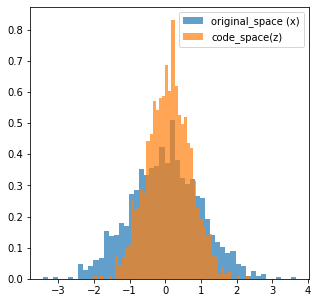

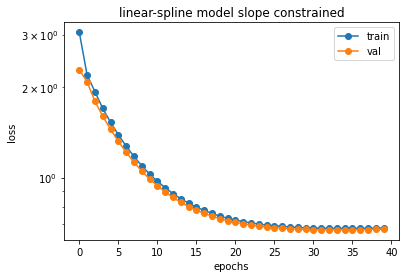

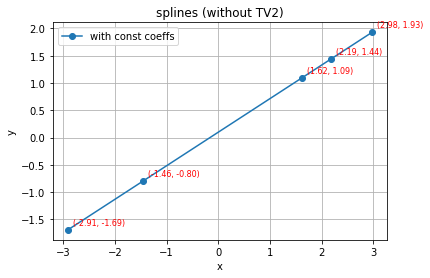

slopes: constrained coeffs: tensor([[0.6150, 0.6150, 0.6150, 0.6151, 0.6150]], grad_fn=<ClampBackward1>)


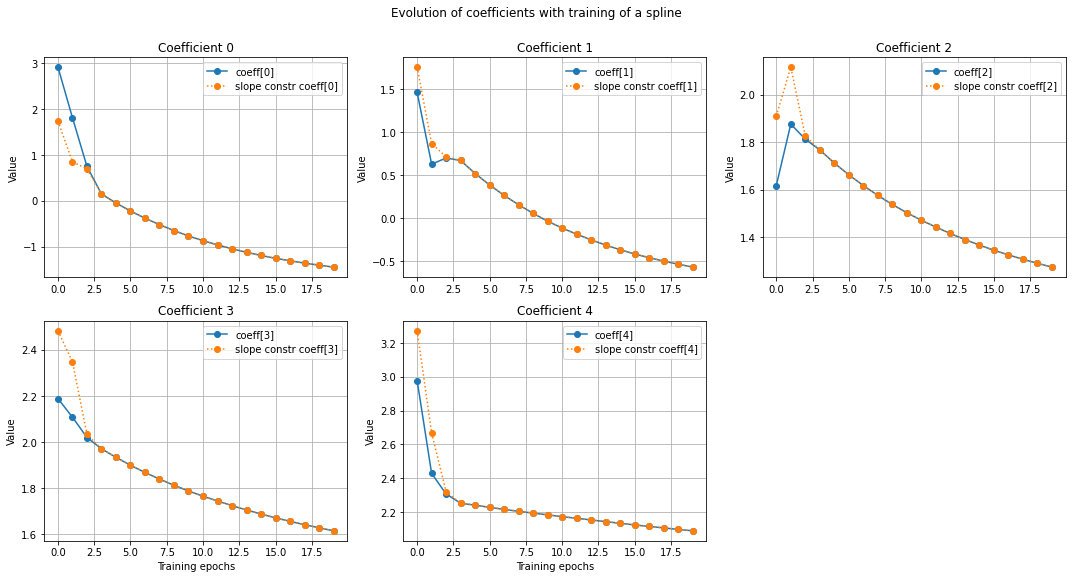

initial nodal_val_locs: tensor([[-2.9132, -1.4608,  1.6172,  2.1882,  2.9779]])
initial fn values: Parameter containing:
tensor([2.9132, 1.4608, 1.6172, 2.1882, 2.9779], requires_grad=True)


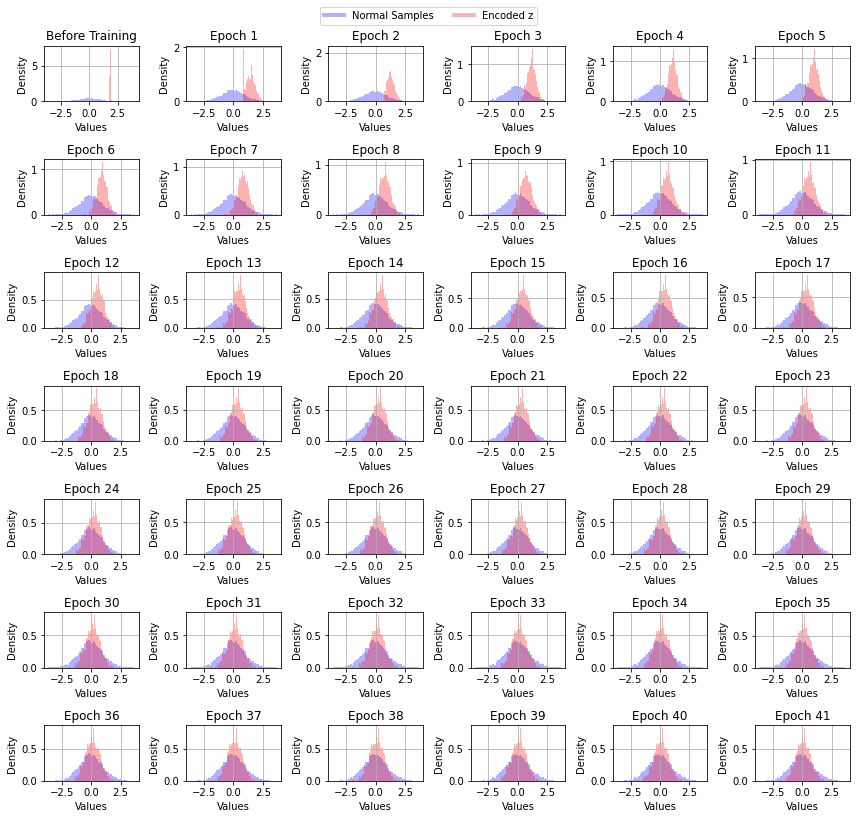

In [147]:
analyse_training(model_in=model2,train_loss=train_loss2+train_loss2_1, val_loss=val_loss2+val_loss2_1, 
                model_params_list=epoch_wise_param_list + epoch_wise_param_list_1,
                test_data=test_data)

# IGNORE EVERYTHING BELOW FOR THE TIME BEING

In [444]:
train_loss21, val_loss21, coeffs_unconstrained_evol21, coeffs_const_evol21 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:26<06:15, 26.85s/it]

Epoch 1/15,  train NLL+2XTV2: 1.7950410302010171, Training NLL Loss: 1.7937681636140197, Validation NLL Loss: 1.675754126548767, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:51<05:35, 25.80s/it]

Epoch 2/15,  train NLL+2XTV2: 1.6104672450537139, Training NLL Loss: 1.6092781132372813, Validation NLL Loss: 1.5081323852539064, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:17<05:07, 25.62s/it]

Epoch 3/15,  train NLL+2XTV2: 1.4560924263570487, Training NLL Loss: 1.454889928492707, Validation NLL Loss: 1.3677404950857162, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:43<04:42, 25.66s/it]

Epoch 4/15,  train NLL+2XTV2: 1.329071256602638, Training NLL Loss: 1.32790742698345, Validation NLL Loss: 1.252764575123787, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [02:11<04:25, 26.58s/it]

Epoch 5/15,  train NLL+2XTV2: 1.2231665623422965, Training NLL Loss: 1.221948386796438, Validation NLL Loss: 1.1561619700193406, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:38<04:02, 26.92s/it]

Epoch 6/15,  train NLL+2XTV2: 1.1352590369483602, Training NLL Loss: 1.1340554538913128, Validation NLL Loss: 1.0762032825946808, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [03:01<03:23, 25.45s/it]

Epoch 7/15,  train NLL+2XTV2: 1.0613585530741152, Training NLL Loss: 1.0600970409421095, Validation NLL Loss: 1.009213008761406, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:25<02:55, 25.06s/it]

Epoch 8/15,  train NLL+2XTV2: 1.0000129800478208, Training NLL Loss: 0.9988170198987668, Validation NLL Loss: 0.9547329425811768, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:49<02:29, 24.86s/it]

Epoch 9/15,  train NLL+2XTV2: 0.9496789782498776, Training NLL Loss: 0.9485391789046536, Validation NLL Loss: 0.908453249335289, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [04:13<02:02, 24.53s/it]

Epoch 10/15,  train NLL+2XTV2: 0.906641029836586, Training NLL Loss: 0.9054285443636119, Validation NLL Loss: 0.8690290504693985, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:37<01:36, 24.21s/it]

Epoch 11/15,  train NLL+2XTV2: 0.8697649293867257, Training NLL Loss: 0.8686097119236564, Validation NLL Loss: 0.8363550344705581, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:59<01:11, 23.68s/it]

Epoch 12/15,  train NLL+2XTV2: 0.839188279662259, Training NLL Loss: 0.8380170094731942, Validation NLL Loss: 0.8080475360155106, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:22<00:46, 23.34s/it]

Epoch 13/15,  train NLL+2XTV2: 0.8120450075355062, Training NLL Loss: 0.8109037162354591, Validation NLL Loss: 0.7841522275209427, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:45<00:23, 23.33s/it]

Epoch 14/15,  train NLL+2XTV2: 0.7901890381545007, Training NLL Loss: 0.7888947354746151, Validation NLL Loss: 0.764464368224144, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [06:09<00:00, 24.63s/it]

Epoch 15/15,  train NLL+2XTV2: 0.7716132789569322, Training NLL Loss: 0.7703813072086504, Validation NLL Loss: 0.74839078271389, LR: 0.0005
Training complete


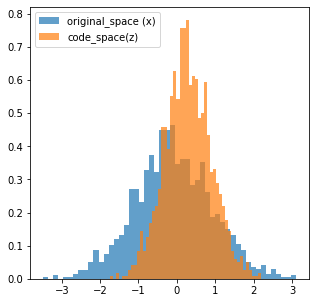

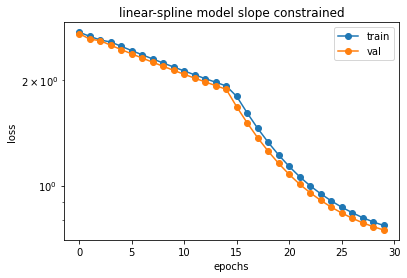

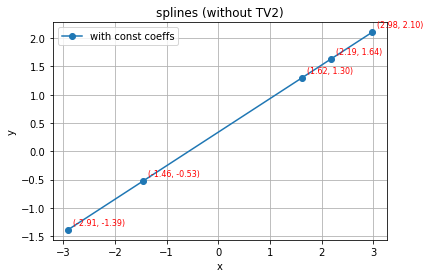

slopes: constrrained coeffs: tensor([[0.5933, 0.5933, 0.5930, 0.5930, 0.5928]], grad_fn=<ClampBackward1>)


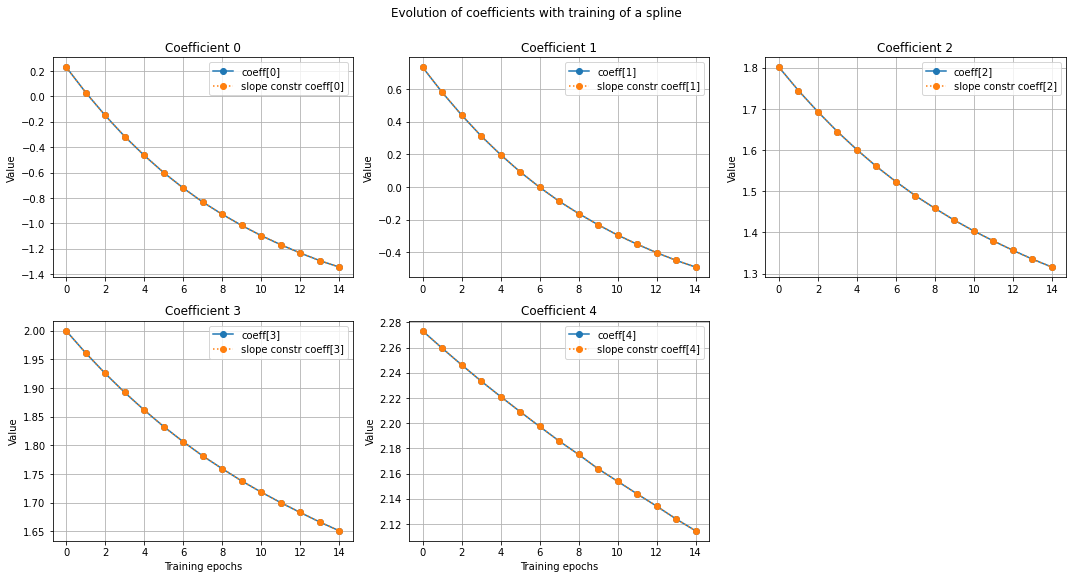

In [445]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21, val_loss=val_loss2+val_loss21,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol21), 
                        np.array(coeffs_const_evol21), log_scale=0)

In [446]:
train_loss22, val_loss22, coeffs_unconstrained_evol22, coeffs_const_evol22 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:25<06:00, 25.75s/it]

Epoch 1/15,  train NLL+2XTV2: 0.7560859116459874, Training NLL Loss: 0.754804031375952, Validation NLL Loss: 0.7327845113277436, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:49<05:22, 24.83s/it]

Epoch 2/15,  train NLL+2XTV2: 0.7421065440470067, Training NLL Loss: 0.7408806334066922, Validation NLL Loss: 0.7220781663656235, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:11<04:39, 23.31s/it]

Epoch 3/15,  train NLL+2XTV2: 0.7314912248035732, Training NLL Loss: 0.7303401065260913, Validation NLL Loss: 0.712250748693943, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:35<04:18, 23.53s/it]

Epoch 4/15,  train NLL+2XTV2: 0.7227154010595577, Training NLL Loss: 0.7215110120373908, Validation NLL Loss: 0.7043339312076569, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [01:59<03:57, 23.71s/it]

Epoch 5/15,  train NLL+2XTV2: 0.7148955892372458, Training NLL Loss: 0.713751832286619, Validation NLL Loss: 0.6975123455524445, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:21<03:29, 23.24s/it]

Epoch 6/15,  train NLL+2XTV2: 0.7077750574091917, Training NLL Loss: 0.7065730575143321, Validation NLL Loss: 0.6915768585801124, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [02:44<03:04, 23.05s/it]

Epoch 7/15,  train NLL+2XTV2: 0.7021780178372229, Training NLL Loss: 0.7009775215167722, Validation NLL Loss: 0.6866017317771912, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:05<02:38, 22.60s/it]

Epoch 8/15,  train NLL+2XTV2: 0.6972290485484435, Training NLL Loss: 0.6960798933425313, Validation NLL Loss: 0.6822464079260826, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:32<02:22, 23.74s/it]

Epoch 9/15,  train NLL+2XTV2: 0.6931972280208535, Training NLL Loss: 0.6920671766654181, Validation NLL Loss: 0.6788052502274513, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [03:53<01:55, 23.05s/it]

Epoch 10/15,  train NLL+2XTV2: 0.690067335580186, Training NLL Loss: 0.6888967712362709, Validation NLL Loss: 0.6763396837711334, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:15<01:30, 22.56s/it]

Epoch 11/15,  train NLL+2XTV2: 0.6874052545354217, Training NLL Loss: 0.686176716400296, Validation NLL Loss: 0.6739527670145035, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:38<01:08, 22.85s/it]

Epoch 12/15,  train NLL+2XTV2: 0.6855675144106685, Training NLL Loss: 0.6843118056488936, Validation NLL Loss: 0.6725790653824806, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:01<00:45, 22.94s/it]

Epoch 13/15,  train NLL+2XTV2: 0.6838009949795896, Training NLL Loss: 0.682651421570737, Validation NLL Loss: 0.671684087574482, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:23<00:22, 22.42s/it]

Epoch 14/15,  train NLL+2XTV2: 0.6824377398130316, Training NLL Loss: 0.6812830328456132, Validation NLL Loss: 0.6705488206744195, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [05:44<00:00, 22.97s/it]

Epoch 15/15,  train NLL+2XTV2: 0.6818717758218346, Training NLL Loss: 0.6807398316103266, Validation NLL Loss: 0.6704583894014359, LR: 0.0005
Training complete


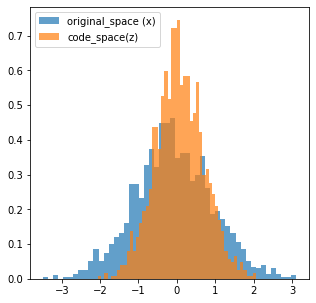

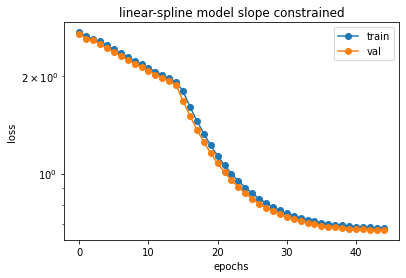

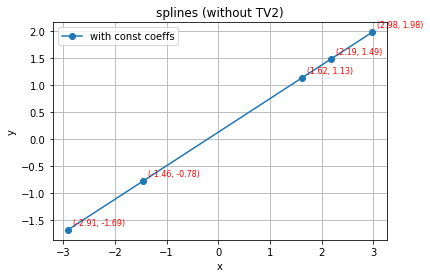

slopes: constrrained coeffs: tensor([[0.6224, 0.6224, 0.6223, 0.6225, 0.6224]], grad_fn=<ClampBackward1>)


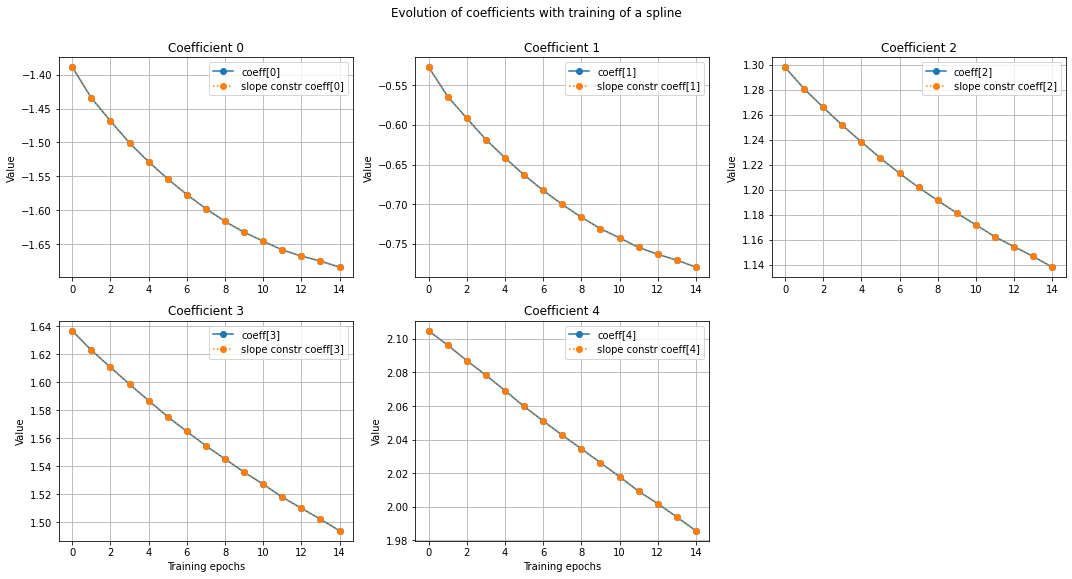

In [449]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21+train_loss22, val_loss=val_loss2+val_loss21+val_loss22,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol22), 
                        np.array(coeffs_const_evol22), log_scale=0)

# everything below is for the negative nodal values case

UPDATE: after using TV2 regularisation, I dont know how correct these conclusions are?

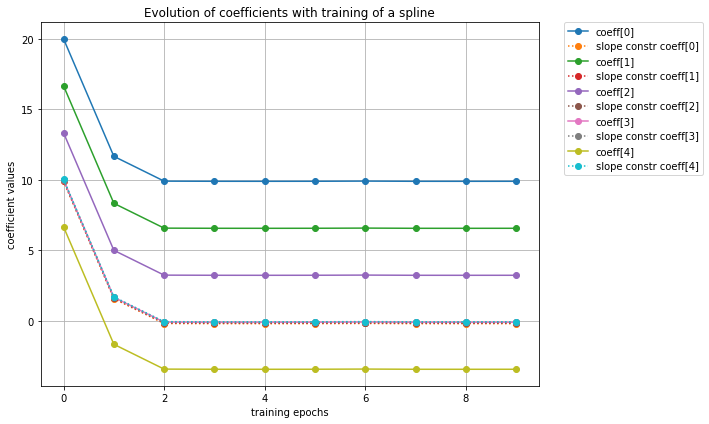

In [117]:
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol2), 
                        np.array(coeffs_const_evol2), log_scale=0)

In [120]:
model2.nodal_val_loc_tensor

tensor([[-20.0000, -16.6667, -13.3333, -10.0000,  -6.6667,  -3.3333,   0.0000]])

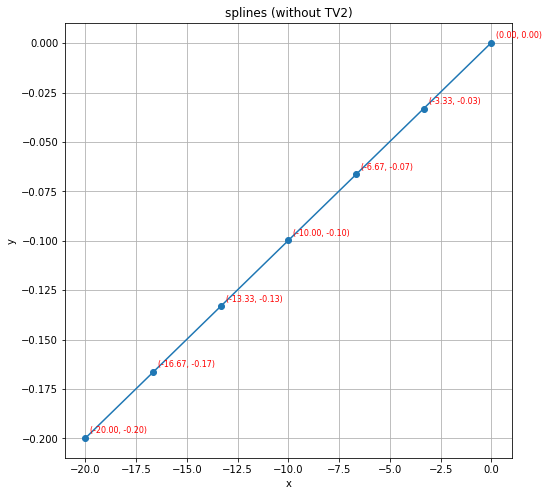

In [121]:
x2,y2= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x2[0], y2,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

### Observation
1. for negative nodal points, learned fn values X10^{-2} off from the correct values 
2. For all +ve nodal points:
    2.1 If i keep range to be 6, SIZE=7 and these nodal values:0.1,1.7,2.7,3.4,4.3,5.1,5.8
    then my slope learned was ~2.
    
    2.2 If i keep range to be 6, SIZE=5 and nodal vals: 0.1,1.7,3.4,4.7,5.8
        ITS A BIT COMPLICATED
    
    2.3 Interesting thing I noted:
        -0.1,0.12,0.7,1.6,3.0 (range 10, but whatever, size=5)
        when i changed 0.7->1.4,0.15, the performance worsened.
       
        (THIS IS EXACTLY WHAT THE AUTHORS ALSO MENTIONED IN THEIR WORK THAT 
        FINDING THE APPROPRIATE POSITION OF NODAL VALUES IS A DIFFICULT 
        TASK. IN THEIR WORK, THEY TRIED TO OVERCOME IT USING TV-2 REGULARISATION)